<a href="https://colab.research.google.com/github/AlexMa123/BIU-Computational-Physics-2022/blob/main/Lecture6%20-%20Monte%20Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo method

## Review

Monte Carlo methods are a broad class of computational algorithms that rely on repeated random sampling to obtain numerical results.

The Monte Carlo Method was invented by John von Neumann and Stanislaw Ulam during World War II to improve decision making under uncertain conditions. Being secret, the work of von Neumann and Ulam required a code name. A colleague of von Neumann and Ulam, Nicholas Metropolis, suggested using the name Monte Carlo, which refers to the `Monte Carlo Casino` in Monaco `where Ulam's uncle would borrow money from relatives to gamble.` (There is also an algorithm called Las Vegas algorithm)

In [ ]:
import numpy as np
from scipy.stats import norm
from numba import njit, vectorize
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Set the random seed

Our computer can only generate Pseudorandom numbers. Once you choose a 'seed', all the 'random' numbers will be fixed.

In [ ]:
np.random.seed(12345)
print(np.random.rand())
print(np.random.rand())

0.9296160928171479
0.3163755545817859


for generate 'real' random number, we can use the system's time as the random seed.

In [ ]:
import time
np.random.seed(int(time.time()))
print(np.random.rand())
print(np.random.rand())

0.8713189669529988
0.4578765611875991


### Monte Carlo Integral
If we what to calculate an integral:
$$I = \int_X f(x) dX$$

We can estimate this integral by a probability distribution

$$I = \int_X \frac{f(x)}{p(x)} p(x)dX = E[\frac{f(x)}{p(x)}]$$

We just need to generate random numbers that are sampled from PDF p(x), and than the integral will become compute the mean value of $\frac{f(x)}{p(x)}$

#### Area of a circle
for calculate the area of a circle, we can define f(x, y) as:
$$
\begin{equation}
f(x, y) = \left \{
\begin{aligned}
1 & & x^2 + y^2 < 1\\
0 & & x^2 + y^2 > 1
\end{aligned}
\right.
\end{equation}
$$

1. Use uniform distribution to estimate the area:
$$
\begin{equation}
p(x, y) = \left \{
\begin{aligned}
1/4 & & -1 < x < 1 \text{ and } -1 < y < 1\\
0 & & \text{other cases}
\end{aligned}
\right.
\end{equation}
$$

In [ ]:
# vectorize will create a numpy ufunc for me, which can allow me use array as the input
@vectorize
def f_to_integral(x, y):
    if x ** 2 + y ** 2 < 1:
        return 1
    else:
        return 0

In [ ]:
N = 1000000
x_uniform = np.random.uniform(-1, 1, N)
y_uniform = np.random.uniform(-1, 1, N)

(f_to_integral(x_uniform, y_uniform) * 4).mean()

3.14152

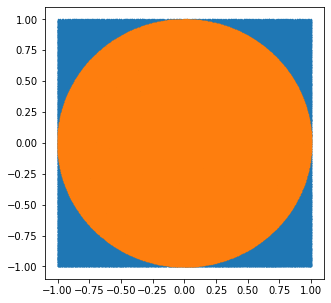

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(x_uniform, y_uniform, '.', markersize=0.5)
plt.plot(x_uniform * f_to_integral(x_uniform, y_uniform),
         y_uniform * f_to_integral(x_uniform, y_uniform),
         '.', markersize=0.5)

plt.show()

2. Estimate from 2d normal distribution

For generate a 2d normal distribution, we can use Box-Muller transform:
If $X_1$ and $X_2$ are independent samples chosen from the uniform distribution on the interval (0, 1)
$$Z_0 = \sqrt{-2 \ln X_1} \cos(2\pi X_2)$$
$$Z_1 = \sqrt{-2 \ln X_1} \sin(2\pi X_2)$$

In [ ]:
def norm_pdf(x, y, mean, cov):
    from scipy.stats import multivariate_normal
    X = np.array([x, y]).T
    return multivariate_normal.pdf(X, mean, cov) 

N = 1000000
cov = np.identity(2) / (2) ** 2

# Box-Muller transform
x_uniform = np.random.uniform(0, 1, N)
y_uniform = np.random.uniform(0, 1, N)

Z0 = np.sqrt(-2 * np.log(x_uniform)) * np.cos(2 * np.pi * y_uniform)
Z1 = np.sqrt(-2 * np.log(x_uniform)) * np.sin(2 * np.pi * y_uniform)
Z0 = Z0 / 2
Z1 = Z1 / 2

p_xy = norm_pdf(Z0, Z1, [0, 0], cov)

(f_to_integral(Z0, Z1) / p_xy).mean()

3.140786008341344

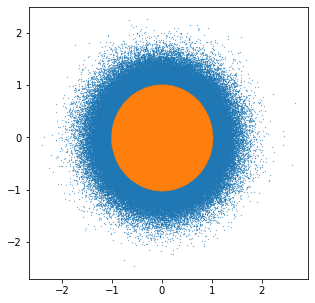

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(Z0, Z1, '.', markersize=0.5)
plt.plot(Z0 * f_to_integral(Z0, Z1),
         Z1 * f_to_integral(Z0, Z1),
         '.', markersize=0.5)

plt.show()

3. compare the results between different p(x)

Although for any p(x), once you generate large enough random numbers, because of the law of large numbers, you will reach the real value, but for different p(x), they will still have different errors.

If we estimate the area by such a distribution:

$$
\begin{equation}
p_1(x, y) = \left \{
\begin{aligned}
1/16 & & -2 < x < 2 \text{ and } -2 < y < 2\\
0 & & \text{other cases}
\end{aligned}
\right.
\end{equation}
$$

most of the random numbers are outside of the circle. It's clear that the error will be larger than a normal distribution with $\sigma=\frac{1}{2.5}$

In [ ]:
results_uniform = np.zeros(1000)
results_normal = np.zeros(1000)
for i in range(1000):
    N = 1000
    x_uniform = np.random.uniform(-2, 2, N)
    y_uniform = np.random.uniform(-2, 2, N)

    results_uniform[i] = (f_to_integral(x_uniform, y_uniform) * 16).mean()
    
    x_uniform = (x_uniform + 2) / 4
    y_uniform = (y_uniform + 2) / 4

    x = np.sqrt(-2 * np.log(x_uniform)) * np.cos(2 * np.pi * y_uniform)
    y = np.sqrt(-2 * np.log(x_uniform)) * np.sin(2 * np.pi * y_uniform)
    x = x / 2
    y = y / 2

    p_xy = norm_pdf(x, y, [0, 0], cov)

    results_normal[i] = (f_to_integral(x, y) / p_xy).mean()

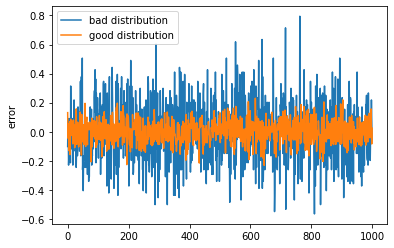

In [ ]:
plt.plot(results_uniform - np.pi, label="bad distribution")
plt.plot(results_normal - np.pi, label="good distribution")
plt.ylabel('error')
plt.legend()
plt.show()

### Sampling method

For solving the integral, only knowing how to sample random numbers from a uniform distribution is not enough. There are some transforms from a uniform distribution to famous distributions, such as normal distribution, Gamma distribution, t distribution, exponent distribution, power-law distribution, and so on. But for the other distributions (like the $|\Psi|^2$ in quantum mechanics), we need to find some numerical methods.

####  von Neumann rejection
This is a simple method for generating random points with a probability distribution $p(x)$ was deduced by von Neumann.

1. choose a "comparison function" $f(x)$ that for any x, $f(x) > p(x)$.

2. generate random pairs $(x_i, y_i)$ with uniform distribution inside $f(x)$

3. Whenever the point lies inside the area of the original probability, $p(x)$, we accept it.

The closer $f(x)$ and $p(x)$ is, the more points will be accepted. Ideally, for $f(x) = p(x)$, no points will be rejected.

##### An example of von Neumann rejection
Let's say p(x) is normal distribution and f(x) is uniform distribution

number of points accpected: 2569
number of points rejected:  7431


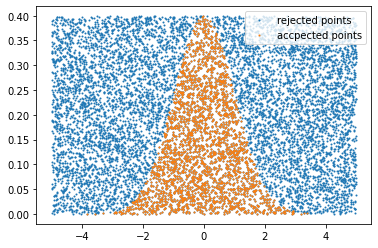

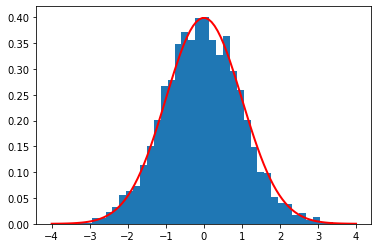

In [ ]:
def norm1d(x):
    from scipy.stats import norm
    return norm.pdf(x,) 
maximum_norm = norm1d(0)
N = 10000
x = np.random.uniform(-5, 5, N)
y = np.random.uniform(0, maximum_norm, N)
plt.figure()
plt.plot(x, y, '.', markersize=2, label="rejected points")
accpected_id = np.where(y < norm1d(x))
x = x[accpected_id]
y = y[accpected_id]
plt.plot(x, y, '.', markersize=2, label="accpected points")
plt.legend()


print(f"number of points accpected: {x.size}")

print(f"number of points rejected:  {N - x.size}")
plt.figure()
plt.hist(x, bins=40, density=True)
x = np.linspace(-4, 4, 100)
plt.plot(x, norm1d(x), 'r-', linewidth=2)
plt.show()

If $f(x)$ is also a standard normal distribution

number of points accpected: 10000
number of points rejected:  0


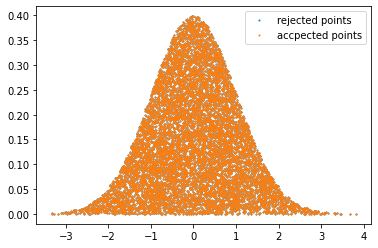

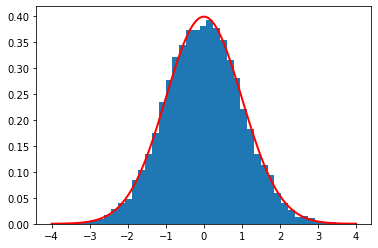

In [ ]:
N = 10000
x = np.random.randn(N)
y = np.random.uniform(np.zeros(x.size), norm1d(x), N)
plt.figure()
plt.plot(x, y, '.', markersize=2, label="rejected points")
accpected_id = np.where(y < norm1d(x))
x = x[accpected_id]
y = y[accpected_id]
plt.plot(x, y, '.', markersize=2, label="accpected points")
plt.legend()


print(f"number of points accpected: {x.size}")

print(f"number of points rejected:  {N - x.size}")
plt.figure()
plt.hist(x, bins=40, density=True)
x = np.linspace(-4, 4, 100)
plt.plot(x, norm1d(x), 'r-', linewidth=2)
plt.show()

#### Markov Chain Monte Carlo (MCMC)
In the late 1940s, Stanislaw Ulam invented the modern version of the Markov Chain Monte Carlo (MCMC) method while he was working on nuclear weapons. 
MCMC methods comprise a class of algorithms for sampling from a probability distribution with the help of markov chain.


##### Markov Chain and stationary distribution

A Markov chain or Markov process is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event.

$$P(X^{t+1}|X^1, X^2, ... X^t) = P(X^{t+1}|X^t)$$

And the transition probabilities are time independent.

![Markov Chain](https://miro.medium.com/max/437/1*SUUir-VGHy2OFqbpKxwuJA.png)

The stationary distribution is a distribution obey:

$$P \pi(s) = \pi(s)$$
##### Detailed balance
If for any two states i and j
$$P(i, j)\pi(i) = P(j, i) \pi(j)$$
$\pi(i)$ is the stationary distribution for the matrix P

##### From Markov Chain to sample from a distribution
The basic idea of MCMC is to find out the transition matrix for a given stationary distribution $\pi$. The earliest algorithm is the Metropolis algorithm, which is introduced in the famous paper: "Equation of State Calculations by Fast Computing Machines". And W. K. Hastings extended it to the more general case in 1970.

#### Metropolis-Hastings Sampling


We don't know the transition matrix, if we just guess a transition matrix Q(i, j), then
$$\pi(i) Q(i, j) \neq \pi(j) Q(j, i)$$

But we can introduce an acceptance rate $\alpha(i, j)$ to make
$$\pi(i) Q(i, j) \alpha(i, j) = \pi(j) Q(j, i) \alpha(j, i)$$

where $\alpha(i, j) = \pi(j) Q(j, i)$

But the system will stay in a state for a very long time when the acceptance rate is very low. To solve this problem, we can greater the probability by times a C on both hand sides, makes $C \alpha(j, i) = 1$, $C \alpha(i, j) = min \{\frac{\pi(j) Q(j, i)}{\pi(i) Q(i, j)}, 1 \}$.

So the step of M-H sampling is:

1. Choose a transition matrix Q

2. Choose a initial state $x_0$

3. for t start from 0 to N

    a. get a new $x_t$ from the transition probability Q(x_t, x_{t-1})
    
    b. sample a random number from Uniform distribution U ~ [0, 1]
    
    c. if $u <  min \{\frac{\pi(j) Q(j, i)}{\pi(i) Q(i, j)}, 1 \}$ accept $x_t$
    
    d. else, x_t = x_{t - 1}
    
For most of the cases, $Q(i, j) = Q(j, i)$, then in step b, we just need to accept $x_t$ when $u <  min \{\frac{\pi(j)}{\pi(i)}, 1 \}$

In [ ]:
# Sample a normal distribution
@njit
def norm_pdf(x, mean=5, sigma=1):
    y = 1 / (sigma * np.sqrt(2 * np.pi))
    y = y * np.exp(- 0.5 * ((x - mean) / sigma) ** 2)
    return y

@njit.
def MH_sampling(N=100000, x0=20):
    walker = np.zeros(N)
    walker[0] = x0
    for i in range(1, N):
        delta_x = np.random.uniform(-1, 1)
        alpha = min(1, norm_pdf(walker[i - 1] + delta_x) / norm_pdf(walker[i - 1]))
        # reject or accept
        if np.random.rand() < alpha: # accept
            walker[i] = walker[i - 1] + delta_x
        else: # reject
            walker[i] = walker[i - 1]
    return walker

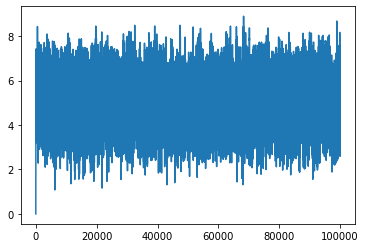

In [ ]:
walker = MH_sampling(x0 = 0)
plt.plot(walker)

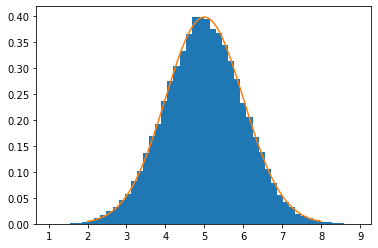

In [ ]:
x = np.linspace(2, 8, 100)
plt.hist(walker[1000:], bins=50, density=True)
plt.plot(x, norm_pdf(x))
plt.show()

But the numbers generated by MCMC are not randomly sampled from a given distribution. In fact, it is positively autocorrelated.

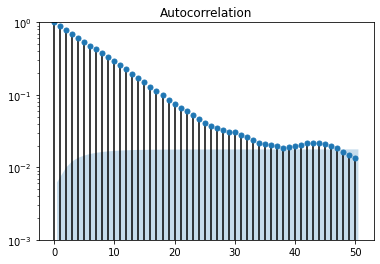

In [ ]:
plot_acf(walker)
plt.yscale('log')
plt.ylim(1e-3, 1)
plt.show()

##### Thermal equilibrium
From statistical mechanics, we know at a given temperature T, the probability distribution that a system will be in a certain state is given by the Boltzmann distribution. We can use the Boltzmann distribution as the stationary distribution in MCMC, then we can sample the system to stay in thermal equilibrium.



###### Ideal gas
Let's simulate the simplest model in thermaldynamics: ideal gas. 

Assume there are N=500 particles, and m=1, $k_B=1$

In [ ]:
@njit
def kinetic_energy(v):
    return np.sum(0.5 * v ** 2)


@njit
def mcmc(Nruns=10000, T=100):
    N_particle = 500
    vs = np.zeros(3 * N_particle)
    Eks = np.zeros(Nruns)
    Eks[0] = kinetic_energy(vs)
    for i in range(1, Nruns):
        new_vs = vs + np.random.uniform(-1, 1, size=vs.size)
        new_e = kinetic_energy(new_vs)
        delta_e = new_e - Eks[i - 1]
        if np.random.rand() < np.exp(- delta_e / T):
            vs = new_vs
            Eks[i] = new_e
        else:
            Eks[i] = Eks[i - 1]
    return Eks, vs



In [ ]:
def Maxwell_distribution(v, T):
    N = np.sqrt(2 * (1 / T) ** 3 / np.pi)
    return N * v ** 2 * np.exp(- v ** 2 / (2 * T))

In [ ]:
T = 273
Ek, vs = mcmc(200000, T=T)

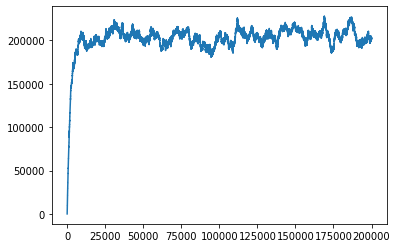

In [ ]:
plt.plot(Ek)
plt.show()

In [ ]:
vs = vs.reshape(-1, 3)
abs_v = np.sqrt(np.sum(vs**2, axis=1))

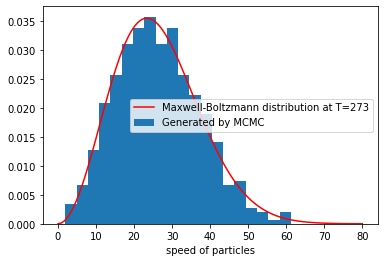

In [ ]:
# Maxwell distribution
v = np.linspace(0, 80, 100)
plt.hist(abs_v, bins=20, density=True, label='Generated by MCMC')
plt.plot(v, Maxwell_distribution(v, T), 'r-', label=f"Maxwell-Boltzmann distribution at T={T}")
plt.xlabel("speed of particles")
plt.legend()
plt.show()

We can also test the equipartition theorem: $\left< E_{kin} \right> = \frac{3}{2} N k_B T = \frac{3}{2} NT$

In [ ]:
mean_Ekin = Ek[25000:].mean() / 500 # 
print("the mean energy for ideal gas is :", mean_Ekin)
print("theortical result is : ", T * 1.5)

the mean energy for ideal gas is : 409.6626502999128
theortical result is :  409.5


##### Integral in quantum mechanics

We always need to calculate expectation value in quantum mechanics. The integral will become very crazy when considering a multibody system, like an atom with lots of electron. (variational method)

Monto Carlo Integral will be a good chose in this case.

Consider the expectation value for an operator $\hat{O}$

$$\left< \hat{O} \right> = \int \mathrm{d}x \psi^* (x) \hat{O} \psi(x) = \int \mathrm{d}x \psi^* (x)\psi(x) \frac{ \hat{O} \psi(x)}{\psi(x)}$$

So for compute the expectation value for an operator, one need to simple random variables from $|\psi(x)|^2$ first, then calculate $\left< \frac{\hat{O} \psi(x)}{\psi(x)} \right>$

##### Quantum harmonic oscillator at n=2

assume $\hbar=1$, $m=1$ and $\omega=1$.

$$ \left\langle x | \psi_n \right\rangle = \sqrt{\frac{1}{2^n\,n!}} \cdot \left(\frac{1}{\pi}\right)^{1/4} \cdot \exp
\left(- \frac{x^2}{2} \right) \cdot H_n\left( x \right) $$

for n = 2

$$\psi_x(x) = \sqrt{\frac{1}{8}} \left( \frac{1}{\pi} \right)^{\frac{1}{4}} \left(-2 + 4 \cdot x^2 \right) e^{- \frac{x^2}{2}} $$

In [ ]:
@njit
def wave_function(x):
    N = np.sqrt(1 / 8) * (1 /  np.pi) ** 0.25
    psi = N * (-2 + 4 * x ** 2) * np.exp(- 0.5 * x ** 2)
    return psi
    
@njit
def MH_sampling(N=100000, x0=0.):
    walker = np.zeros(N)
    walker[0] = x0
    p_now = wave_function(x0) ** 2
    for i in range(1, N):
        delta_x = np.random.uniform(-1, 1)
        p_next = wave_function(walker[i-1] + delta_x) ** 2
        alpha = min(1, p_next / p_now)
        # reject of accept
        if np.random.rand() < alpha:
            p_now = p_next
            walker[i] = walker[i - 1] + delta_x
        else:
            walker[i] = walker[i - 1]
    return walker

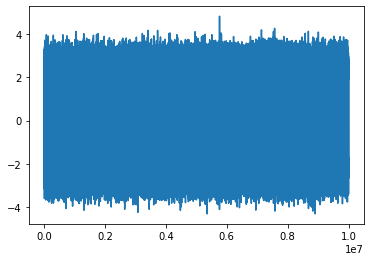

In [ ]:
walkers = MH_sampling(10000000)
plt.plot(walkers)

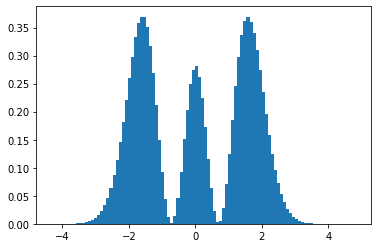

In [ ]:
plt.hist(walkers, bins=100, density=True)
plt.show()

$\left< x \right> = 0$

In [ ]:
walkers.mean()

-0.00402332149207968

$\left< E_{kin} \right>=\left< E_{pot} \right> = \frac{1}{2} \times  (2 + \frac{1}{2}) = 1.25$

mean potential: $\frac{1}{2} \left< x^2 \right>$

In [ ]:
mean_pot = 0.5 * (walkers ** 2).mean()
print("mean potential is : ", mean_pot)

mean potential is :  1.2496941015507954


mean kinetic energy: $-\frac{1}{2}\left<\frac{ \nabla^2 \psi(x)}{\psi(x)} \right> = 1.25$

In [ ]:
from jax import grad, vmap
import jax.numpy as jnp


def wave_function_jax(x):
    N = jnp.sqrt(1 / 8) * (1 /  jnp.pi) ** 0.25
    psi = N * (-2 + 4 * x ** 2) * jnp.exp(- 0.5 * x ** 2)
    return psi

laplacian = vmap(grad(grad(wave_function_jax)))
# Mean kinetic Energy

mean_kin = -0.5 * np.mean(laplacian(walkers) / wave_function_jax(walkers))
print("mean kinetic energy is : ", mean_kin)

mean kinetic energy is :  1.2503059


MCMC is not only useful for physics but also very useful for data science, and artificial intellegance.

In tensorflow_probability (a python package from google), there is an mcmc module including lots of sampling methods. (For more detail, please visit: https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc)

## Exercise

1. Summarize


2. Compute the volume of the ball in 10 dimensions

3. Ideal gas with gravity

a. Instead of considering the velocity distribution as in the example above, determine the distribution of the particles as a function of the height. (***Note: the height for each particle can't larger than 0***)

b. describe what is the equipartition theorem， then calculate the mean gravitational energy and mean kinetic energy theoretically and numerically. 


4. Compute $\left< \frac{1}{r} \right>$ for the hydrogen atom at states l=0, n = 2. (assume the Bohr radius equal to 1)

scipy.special.assoc_laguerre(x, n, k) can be used to get the generalized (associated) Laguerre polynomial of degree n and order k : $L_n^{(k)}$.